In [5]:
import os
import numpy as np
from ase.io import read
from mace.calculators import MACECalculator

# === Config ===
cif_path = "/home/phanim/harshitrawat/summer/md/mdcifs_strained_perturbed_prime/cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0006_strain+0.010_perturbed.cif"
model_path = "/home/phanim/harshitrawat/summer/checkpoints/mace_T1_finetune_h200_cn10_run-21.model"

# === Load model
calc = MACECalculator(model_path=model_path, device="cuda:0")
print("✅ Model loaded")

# === Read CIF and predict
atoms = read(cif_path)
atoms.calc = calc

energy = atoms.get_potential_energy()
forces = atoms.get_forces()
fmax = np.max(np.linalg.norm(forces, axis=1))
n_atoms = len(atoms)

# === Check
print(f"\n📂 File: {os.path.basename(cif_path)}")
print(f"🔋 Energy: {energy:.4f} eV")
print(f"🧪 Fmax: {fmax:.4f} eV/Å")
print(f"🔢 Num atoms: {n_atoms}")
print(f"📐 Forces shape: {forces.shape}")

assert forces.shape == (n_atoms, 3), "❌ Mismatch in forces shape!"
print("✅ Forces match atom count.")

# === Optional: Print first 3 forces
print("\n🔍 Sample forces (first 3 atoms):")
for i in range(min(3, n_atoms)):
    print(f"  Atom {i+1}: {forces[i]}")


/home/phanim/harshitrawat/mace/mace/calculators/mace.py:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.
✅ Model loaded

📂 File: cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0006_strain+0.010_perturbed.cif
🔋 Energy: -2766.5110 eV
🧪 Fmax: 1.1510 eV/Å
🔢 Num atoms: 648
📐 Forces shape: (648, 3)
✅ Forces match atom count.

🔍 Sample forces (first 3 atoms):
  Atom 1: [0.01448724 0.27324329 0.06818117]
  Atom 2: [-0.24365983  0.1434739   0.26062984]
  Atom 3: [-0.00368593 -0.04851692 -0.15535602]


In [6]:
#!/usr/bin/env python3
import os
import json
import numpy as np
from ase.io import read
from ase.calculators.calculator import CalculatorError
from mace.calculators import MACECalculator

# === Config ===
folder = "/home/phanim/harshitrawat/summer/md/mdcifs_strained_perturbed_prime"
model_path = "/home/phanim/harshitrawat/summer/checkpoints/mace_T1_finetune_h200_cn10_run-21.model"
output_json = "/home/phanim/harshitrawat/summer/md/mdinfo_mace_predictions_T3prime.json"

# === Load MACE model
calc = MACECalculator(model_path=model_path, device="cuda:0")
print("✅ Loaded MACE model on cuda:0")

# === Main function
def extract_info_from_cif(cif_path):
    try:
        atoms = read(cif_path)
        atoms.calc = calc
        energy = atoms.get_potential_energy()
        forces = atoms.get_forces()
        fmax = np.max(np.linalg.norm(forces, axis=1))
        stress = atoms.get_stress(voigt=False).tolist()

        if forces.shape[0] != len(atoms):
            raise ValueError(f"Force shape mismatch: {forces.shape} vs {len(atoms)}")

        return {
            "file": os.path.basename(cif_path),
            "energy_eV": energy,
            "fmax_eV_per_A": fmax,
            "forces_per_atom_eV_per_A": forces.tolist(),
            "stress_tensor": stress,
        }

    except (CalculatorError, Exception) as e:
        return {"file": os.path.basename(cif_path), "error": str(e)}

# === Batch process
results = []
cif_files = sorted([f for f in os.listdir(folder) if f.endswith(".cif")])
total = len(cif_files)

for i, fname in enumerate(cif_files, 1):
    path = os.path.join(folder, fname)
    result = extract_info_from_cif(path)
    results.append(result)

    tag = "✅" if "error" not in result else "❌"
    msg = result["error"] if "error" in result else ""
    print(f"{tag} [{i}/{total}] {fname} {msg}")

# === Save to JSON
with open(output_json, "w") as f:
    json.dump(results, f, indent=2)

print(f"\n🧾 Clean predictions saved to: {output_json}")


/home/phanim/harshitrawat/mace/mace/calculators/mace.py:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.
✅ Loaded MACE model on cuda:0
✅ [1/1612] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0006_strain+0.010_perturbed.cif 
✅ [2/1612] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0006_strain+0.015_perturbed.cif 
✅ [3/1612] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0006_strain-0.010_perturbed.cif 
✅ [4/1612] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0006_strain-0.015_perturbed.cif 
✅ [5/1612] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0007_strain+0.010_perturbed.cif 
✅ [6/1612] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0007_strain+0.015_perturbed.cif 
✅ [7/1612] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0007_strain-0.010_perturbed.cif 
✅ [8/1612] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0007_strain-0.015_perturbed.cif 
✅ [9/1612] cellrelaxed_LLZO_001_Zr_code93_sto_

In [ ]:
#!/usr/bin/env python3
import os
import json
import numpy as np
from ase.io import read
from ase.calculators.calculator import CalculatorError
from mace.calculators import MACECalculator

# === Config ===
base_dir = "/home/phanim/harshitrawat/summer/md"
folders = ["mdcifs", "mdcifs_strained_perturbed"]
model_path = "/home/phanim/harshitrawat/summer/mace_T3_finetune_h200_cn10_compiled.model"
output_json = os.path.join(base_dir, "mdinfo_macet2_predictions_onT1.json")

# === Load MACE model
calc = MACECalculator(model_path=model_path, device="cuda:0")
print("✅ Loaded MACE model on cuda:0")

# === Main function
def extract_info_from_cif(cif_path, folder):
    try:
        atoms = read(cif_path)
        atoms.calc = calc
        energy = atoms.get_potential_energy()
        forces = atoms.get_forces()
        fmax = np.max(np.linalg.norm(forces, axis=1))
        stress = atoms.get_stress(voigt=False).tolist()

        if forces.shape[0] != len(atoms):
            raise ValueError(f"Force shape mismatch: {forces.shape} vs {len(atoms)}")

        return {
            "file": os.path.basename(cif_path),
            "subfolder": folder,
            "energy_eV": energy,
            "fmax_eV_per_A": fmax,
            "forces_per_atom_eV_per_A": forces.tolist(),
            "stress_tensor": stress,
        }

    except (CalculatorError, Exception) as e:
        return {
            "file": os.path.basename(cif_path),
            "subfolder": folder,
            "error": str(e),
        }

# === Gather all .cif files
all_cif_files = []
for folder in folders:
    full_path = os.path.join(base_dir, folder)
    all_cif_files.extend([
        (os.path.join(full_path, fname), folder)
        for fname in sorted(os.listdir(full_path))
        if fname.endswith(".cif")
    ])

# === Predict
results = []
total = len(all_cif_files)
for i, (cif_path, folder) in enumerate(all_cif_files, 1):
    fname = os.path.basename(cif_path)
    result = extract_info_from_cif(cif_path, folder)
    results.append(result)

    tag = "✅" if "error" not in result else "❌"
    msg = "" if "error" not in result else f"— {result['error']}"
    print(f"{tag} [{i}/{total}] {fname} {msg}")

# === Save to JSON
with open(output_json, "w") as f:
    json.dump(results, f, indent=2)

print(f"\n🧾 Clean predictions saved to: {output_json}")


/home/phanim/harshitrawat/mace/mace/calculators/mace.py:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_location=device)
/home/phanim/harshit

Using head Default out of ['Default']
No dtype selected, switching to float64 to match model dtype.
✅ Loaded MACE model on cuda:0
✅ [1/7042] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0000.cif 
✅ [2/7042] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0001.cif 
✅ [3/7042] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0002.cif 
✅ [4/7042] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0003.cif 
✅ [5/7042] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0004.cif 
✅ [6/7042] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0005.cif 
✅ [7/7042] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0006.cif 
✅ [8/7042] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0007.cif 
✅ [9/7042] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0008.cif 
✅ [10/7042] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T300_0009.cif 
✅ [11/7042] cellrelaxed_LLZO_001_Zr_code93_sto__Li_100_slab_heavy_T30

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import ast

# === Config ===
k_energy = 2
k_force = 2

chgnet_t1 = "/home/phanim/harshitrawat/summer/T1_T2_T3_data/mdinfo_chgnet_predictions_forces.json"
chgnet_t2 = "/home/phanim/harshitrawat/summer/T1_T2_T3_data/strain_perturb_chgnet_predictions_forces.json"
chgnet_t3 = "/home/phanim/harshitrawat/summer/T1_T2_T3_data/strain_perturb_primechgnet_predictions_forces.json"
mace_t3_on_t1 = "/home/phanim/harshitrawat/summer/md/mdinfo_macet2_predictions_onT1.json"
mace_t1_on_t3 = "/home/phanim/harshitrawat/summer/md/mdinfo_mace_predictions_T3prime.json"

output_json = "/home/phanim/harshitrawat/summer/final_work/ood_ensemble_dynamic_k2.json"
output_excel = output_json.replace(".json", ".xlsx")

def safe_parse_forces(f):
    try:
        if isinstance(f, str):
            return np.array(ast.literal_eval(f), dtype=np.float32)
        return np.array(f, dtype=np.float32)
    except:
        return None

def to_float(x, ndigits=5):
    try:
        return float(round(x, ndigits))
    except:
        return np.nan

def load_json(path):
    with open(path) as f:
        return json.load(f)

# === Load CHGNet references
chgnet_data = load_json(chgnet_t1) + load_json(chgnet_t2) + load_json(chgnet_t3)
chgnet_ref = {entry["file"]: entry for entry in chgnet_data if "error" not in entry}

# === Load MACE predictions with model tagging
def label_model(source_path):
    if "T3prime" in source_path:
        return "MACE_T1"
    elif "macet2" in source_path:
        return "MACE_T3"
    else:
        return "Unknown"

mace_preds = {}
for source_path in [mace_t3_on_t1, mace_t1_on_t3]:
    model_tag = label_model(source_path)
    for entry in load_json(source_path):
        entry["model"] = model_tag
        fname = entry["file"]
        mace_preds.setdefault(fname, []).append(entry)

# === First pass: calculate errors
raw_errors = []
failed_entries = []

for file, ref in tqdm(chgnet_ref.items(), desc="Collecting error stats"):
    if file not in mace_preds:
        failed_entries.append((file, "missing_mace_prediction"))
        continue

    pred_list = mace_preds[file]
    energies = [p["energy_eV"] for p in pred_list]
    forces_list = [safe_parse_forces(p["forces_per_atom_eV_per_A"]) for p in pred_list]
    forces_list = [f for f in forces_list if f is not None]

    ref_forces = safe_parse_forces(ref["forces_per_atom_eV_per_A"])
    if len(forces_list) == 0:
        failed_entries.append((file, "no_valid_forces_in_preds"))
        continue
    if ref_forces is None:
        failed_entries.append((file, "invalid_ref_forces"))
        continue
    if any(f.shape != ref_forces.shape for f in forces_list):
        failed_entries.append((file, "force_shape_mismatch"))
        continue

    avg_energy = np.mean(energies)
    avg_forces = np.mean(forces_list, axis=0)
    num_atoms = len(ref_forces)

    energy_error = abs(avg_energy / num_atoms - ref["energy_eV"] / num_atoms)
    force_rmse = np.sqrt(np.mean(np.linalg.norm(avg_forces - ref_forces, axis=1) ** 2))
    raw_errors.append((file, energy_error, force_rmse))

# === Thresholds
energy_vals = np.array([x[1] for x in raw_errors])
force_vals = np.array([x[2] for x in raw_errors])
mu_E, std_E = float(energy_vals.mean()), float(energy_vals.std())
mu_F, std_F = float(force_vals.mean()), float(force_vals.std())
thresh_E = mu_E + k_energy * std_E
thresh_F = mu_F + k_force * std_F

print(f"\n✅ Dynamic thresholds (k={k_energy}, {k_force}):")
print(f"  Energy: {thresh_E:.5f} eV/atom (μ={mu_E:.5f}, σ={std_E:.5f})")
print(f"  Force : {thresh_F:.5f} eV/Å    (μ={mu_F:.5f}, σ={std_F:.5f})")

# === Second pass: evaluate
results = []
for file, energy_error, force_rmse in tqdm(raw_errors, desc="Evaluating OOD"):
    ref = chgnet_ref[file]
    pred_list = mace_preds[file]
    ref_forces = safe_parse_forces(ref["forces_per_atom_eV_per_A"])
    num_atoms = len(ref_forces)

    flagged = []
    for p in pred_list:
        f_i = safe_parse_forces(p["forces_per_atom_eV_per_A"])
        if f_i is None or f_i.shape != ref_forces.shape:
            continue
        e_err = abs(p["energy_eV"] / num_atoms - ref["energy_eV"] / num_atoms)
        f_err = np.sqrt(np.mean(np.linalg.norm(f_i - ref_forces, axis=1) ** 2))
        if e_err > thresh_E or f_err > thresh_F:
            flagged.append(p.get("model", "Unknown"))

    results.append({
        "file": file,
        "energy_abs_error_per_atom": to_float(energy_error),
        "force_per_atom_RMSE": to_float(force_rmse),
        "is_OOD": bool(energy_error > thresh_E or force_rmse > thresh_F),
        "flagged_by_models": flagged
    })

# === Summary
ood_count = sum(r["is_OOD"] for r in results)
print(f"\n📊 OOD Summary:")
print(f"Total structures         : {len(results)}")
print(f"Total OOD structures     : {ood_count}")
print(f"Total Non-OOD            : {len(results) - ood_count}")

# === Save
output_data = {
    "metadata": {
        "k_energy": int(k_energy),
        "k_force": int(k_force),
        "thresh_E": float(thresh_E),
        "thresh_F": float(thresh_F),
        "mu_E": float(mu_E),
        "std_E": float(std_E),
        "mu_F": float(mu_F),
        "std_F": float(std_F),
        "num_failed": int(len(failed_entries))
    },
    "results": results,
    "failures": failed_entries
}

with open(output_json, "w") as f:
    json.dump(output_data, f, indent=2)

pd.DataFrame(results).to_excel(output_excel, index=False)
print(f"\n💾 Saved to: {output_json}")
print(f"💾 Saved to: {output_excel}")



✅ Dynamic thresholds (k=2, 2):
  Energy: 0.00898 eV/atom (μ=0.00260, σ=0.00319)
  Force : 0.09561 eV/Å    (μ=0.04694, σ=0.02433)


Evaluating OOD: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8654/8654 [00:02<00:00, 3897.27it/s]



📊 OOD Summary:
Total structures         : 8654
Total OOD structures     : 1108
Total Non-OOD            : 7546

💾 Saved to: /home/phanim/harshitrawat/summer/final_work/ood_ensemble_dynamic_k2.json
💾 Saved to: /home/phanim/harshitrawat/summer/final_work/ood_ensemble_dynamic_k2.xlsx


In [23]:
import json
import numpy as np
from collections import Counter

# === Load results
path = "/home/phanim/harshitrawat/summer/final_work/ood_ensemble_dynamic_k2.json"
with open(path) as f:
    data = json.load(f)

results = data["results"]

energy_err = np.array([d["energy_abs_error_per_atom"] for d in results])
force_rmse = np.array([d["force_per_atom_RMSE"] for d in results])
is_ood = np.array([d["is_OOD"] for d in results])

# Use thresholds from metadata
mu_E = data["metadata"]["mu_E"]
std_E = data["metadata"]["std_E"]
mu_F = data["metadata"]["mu_F"]
std_F = data["metadata"]["std_F"]
thresh_E = data["metadata"]["thresh_E"]
thresh_F = data["metadata"]["thresh_F"]

# === Global stats
total = len(results)
n_ood = int(np.sum(is_ood))
n_non_ood = total - n_ood
ood_pct = (n_ood / total) * 100

# === Per-model breakdown
flagged_lists = [
    tuple(sorted(d["flagged_by_models"])) if d["flagged_by_models"] else ("None",)
    for d in results if d["is_OOD"]
]
flag_counter = Counter(flagged_lists)

# === Print
print("📊 OOD Ensemble Evaluation Stats (Dynamic Thresholding):")
print(f"Total structures         : {total}")
print(f"Total OOD structures     : {n_ood}")
print(f"Total Non-OOD            : {n_non_ood}")
print(f"OOD rate                 : {ood_pct:.2f}%")

print("\n📍 Per-model OOD breakdown:")
if flag_counter:
    for combo, count in flag_counter.items():
        label = " & ".join(combo) if combo != ("None",) else "None"
        print(f"  {label:12s}: {count} structures")
else:
    print("  No structures flagged by any individual model.")

print("\n📈 Error Distribution Stats (in eV):")
print(f"Energy Abs Error (eV/atom):")
print(f"  mean   = {mu_E:.5f}")
print(f"  stddev = {std_E:.5f}")
print(f"  OOD threshold (μ + 2σ) = {thresh_E:.5f}")

print(f"\nForce RMSE (eV/Å):")
print(f"  mean   = {mu_F:.5f}")
print(f"  stddev = {std_F:.5f}")
print(f"  OOD threshold (μ + 2σ) = {thresh_F:.5f}")


📊 OOD Ensemble Evaluation Stats (Dynamic Thresholding):
Total structures         : 8654
Total OOD structures     : 1108
Total Non-OOD            : 7546
OOD rate                 : 12.80%

📍 Per-model OOD breakdown:
  MACE_T3     : 237 structures
  MACE_T1     : 871 structures

📈 Error Distribution Stats (in eV):
Energy Abs Error (eV/atom):
  mean   = 0.00260
  stddev = 0.00319
  OOD threshold (μ + 2σ) = 0.00898

Force RMSE (eV/Å):
  mean   = 0.04694
  stddev = 0.02433
  OOD threshold (μ + 2σ) = 0.09561


✅ Saved: energy_error_distribution.png, force_rmse_distribution.png


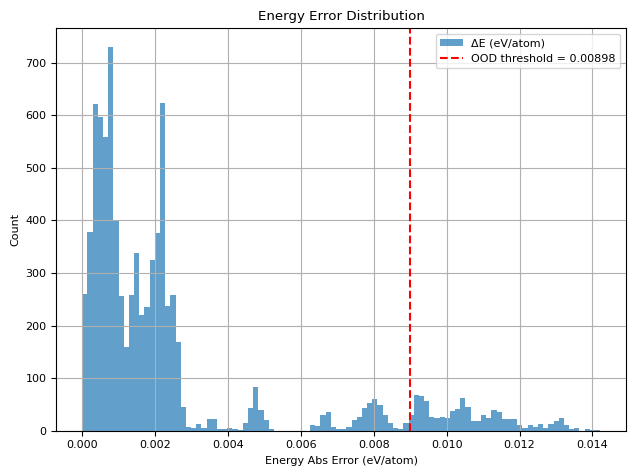

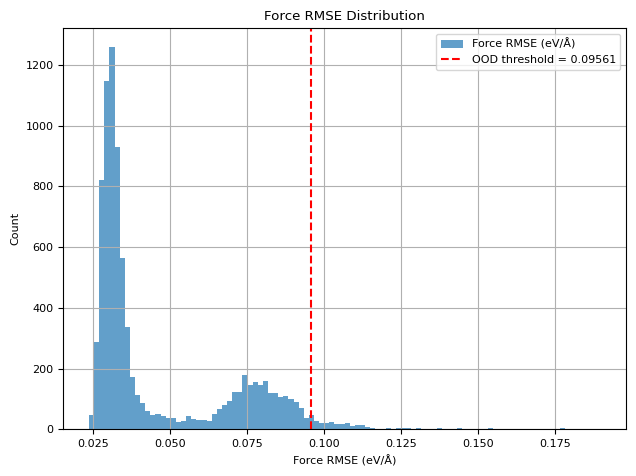

In [24]:
import json
import numpy as np
import matplotlib.pyplot as plt

# === Load results
with open("/home/phanim/harshitrawat/summer/final_work/ood_ensemble_dynamic_k2.json") as f:
    data = json.load(f)
results = data["results"]

# Extract values
energy_err = np.array([d["energy_abs_error_per_atom"] for d in results])
force_rmse = np.array([d["force_per_atom_RMSE"] for d in results])
is_ood = np.array([d["is_OOD"] for d in results])

# Thresholds
thresh_E = data["metadata"]["thresh_E"]
thresh_F = data["metadata"]["thresh_F"]

# === Plot Energy Abs Error
plt.figure()
plt.hist(energy_err, bins=100, alpha=0.7, label="ΔE (eV/atom)")
plt.axvline(thresh_E, color='r', linestyle='--', label=f'OOD threshold = {thresh_E:.5f}')
plt.xlabel("Energy Abs Error (eV/atom)")
plt.ylabel("Count")
plt.title("Energy Error Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("energy_error_distribution.png")

# === Plot Force RMSE
plt.figure()
plt.hist(force_rmse, bins=100, alpha=0.7, label="Force RMSE (eV/Å)")
plt.axvline(thresh_F, color='r', linestyle='--', label=f'OOD threshold = {thresh_F:.5f}')
plt.xlabel("Force RMSE (eV/Å)")
plt.ylabel("Count")
plt.title("Force RMSE Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("force_rmse_distribution.png")

print("✅ Saved: energy_error_distribution.png, force_rmse_distribution.png")



✅ Parsed 1108 / 1108 filenames

📊 Breakdown by STOICHIOMETRY:
  off       : 627
  sto       : 481

📊 Breakdown by TERMINATION:
  Li        : 406
  Zr        : 389
  La        : 313

📊 Breakdown by LLZO_CLEAVE:
  010       : 627
  001       : 389
  011       : 92

📊 Breakdown by LI_FACET:
  110       : 466
  111       : 450
  100       : 192

📊 Breakdown by TEMPERATURE:
  300       : 559
  450       : 549

📊 Breakdown by STRAINED:
  yes       : 995
  no        : 113

✅ All plots saved: ood_by_<key>.png


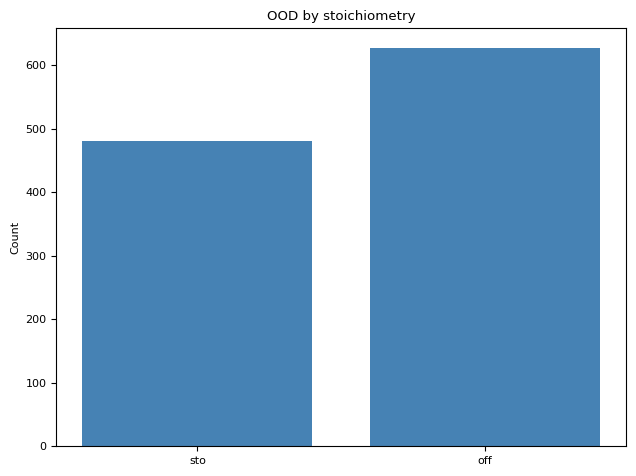

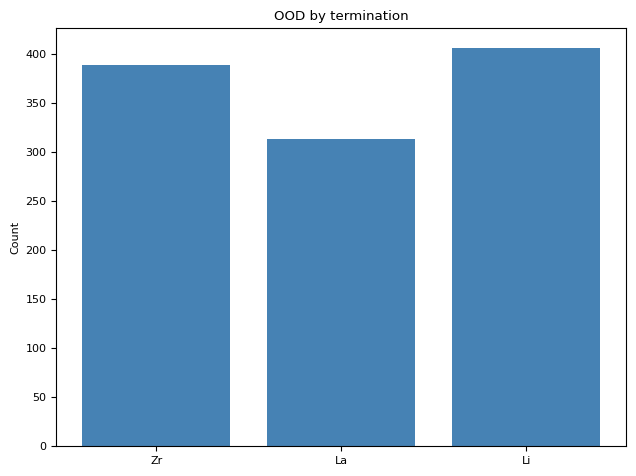

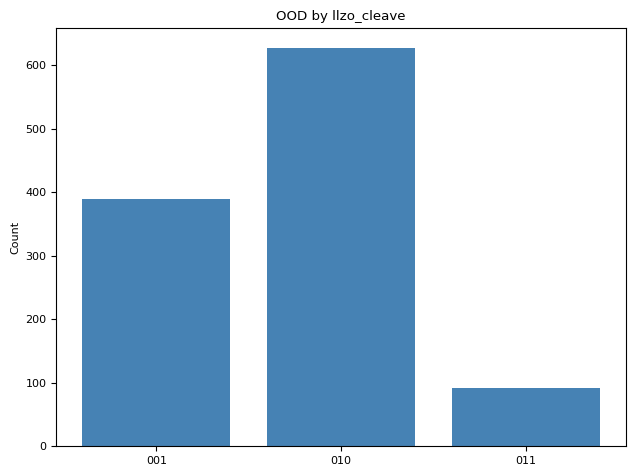

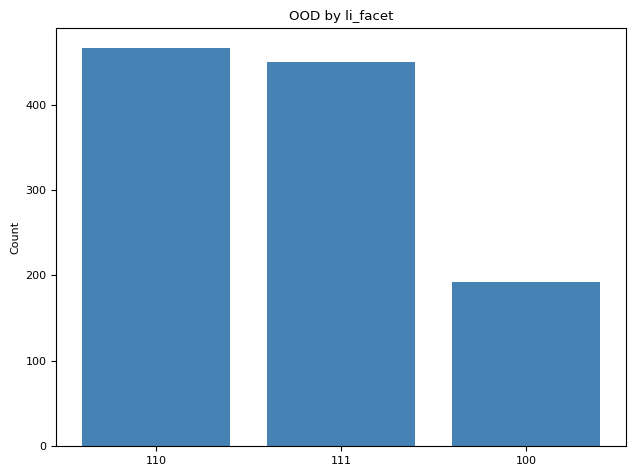

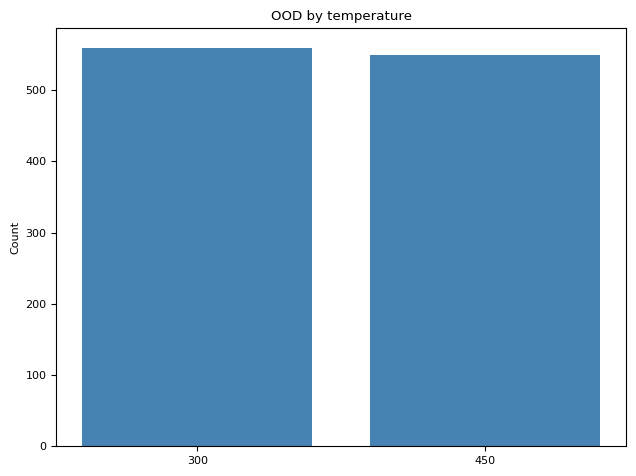

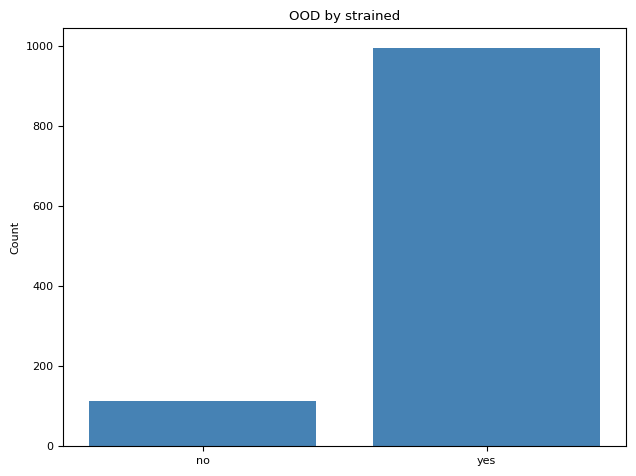

In [33]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt

# === Load OOD results
json_path = "/home/phanim/harshitrawat/summer/final_work/ood_ensemble_dynamic_k2.json"
with open(json_path) as f:
    data = json.load(f)
ood_files = [d["file"] for d in data["results"] if d["is_OOD"]]

# === Final parser, skipping order, capturing integer or float strain
pattern = re.compile(
    r"^cellrelaxed_LLZO_"
      r"(?P<llzo_cleave>\d+)_"
      r"(?P<termination>[A-Za-z]+)_"
      r"[^_]+_"                             # skip the 'order...' segment
      r"(?P<sto>sto|off)__Li_"
      r"(?P<li_facet>\d+)_slab_heavy_"
      r"T(?P<temperature>300|450)_\d{4}"
      r"(?P<strain_tag>_strain[+\-]?\d+(?:\.\d+)?)?"  # integer or decimal
      r"(?:_perturbed)?\.cif$"
)

def extract_fields(fname):
    m = pattern.match(fname)
    if not m:
        return None
    g = m.groupdict()
    return {
        "llzo_cleave":   g["llzo_cleave"],
        "termination":   g["termination"],
        "stoichiometry": g["sto"],
        "li_facet":      g["li_facet"],
        "temperature":   g["temperature"],
        "strained":      "yes" if g["strain_tag"] else "no"
    }

# === Parse all
parsed, failed = [], []
for f in ood_files:
    p = extract_fields(f)
    if p:
        parsed.append(p)
    else:
        failed.append(f)

print(f"\n✅ Parsed {len(parsed)} / {len(ood_files)} filenames")
if failed:
    print(f"❌ Failed to parse {len(failed)} filenames (first 5):")
    for x in failed[:5]:
        print("   ", x)

# === Breakdown helper
def breakdown(key):
    ctr = Counter(p[key] for p in parsed)
    print(f"\n📊 Breakdown by {key.upper()}:")
    for val, cnt in ctr.most_common():
        print(f"  {val:10s}: {cnt}")
    return ctr

# === Print & Plot
keys = ["stoichiometry", "termination", "llzo_cleave", "li_facet", "temperature", "strained"]
counts = {k: breakdown(k) for k in keys}

for k, ctr in counts.items():
    plt.figure()
    labels, vals = zip(*ctr.items())
    plt.bar(labels, vals, color="steelblue")
    plt.title(f"OOD by {k}")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"ood_by_{k}.png")
print("\n✅ All plots saved: ood_by_<key>.png")


We will now do it differently for T1 and T2 mace 

In [42]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import ast
from collections import defaultdict

# === Config ===
k = 1.5  # threshold multiplier
chgnet_ref_json = [
    "/home/phanim/harshitrawat/summer/final_work/mdinfo_chgnet_predictions_forces.json",
    "/home/phanim/harshitrawat/summer/final_work/strain_perturb_chgnet_predictions_forces.json",
    "/home/phanim/harshitrawat/summer/final_work/strain_perturb_primechgnet_predictions_forces.json"
]

mace_t1_json = "/home/phanim/harshitrawat/summer/md/mdinfo_mace_predictions_T3prime.json"     # MACE_T1 on T2
mace_t3_json = "/home/phanim/harshitrawat/summer/md/mdinfo_macet2_predictions_onT1.json"     # MACE_T3 on T1

output_json = "/home/phanim/harshitrawat/summer/final_work/ood_per_model_dynamic.json"
output_excel = output_json.replace(".json", ".xlsx")

def safe_parse_forces(f):
    try:
        if isinstance(f, str):
            return np.array(ast.literal_eval(f), dtype=np.float32)
        return np.array(f, dtype=np.float32)
    except:
        return None

def to_float(x, ndigits=5):
    try:
        return float(round(x, ndigits))
    except:
        return np.nan

def load_json(path):
    with open(path) as f:
        return json.load(f)

# === Load CHGNet reference
ref_data = []
for path in chgnet_ref_json:
    ref_data += load_json(path)
chgnet_ref = {e["file"]: e for e in ref_data if "error" not in e}

# === Load MACE predictions, tag by correct model name
def tag_model(source_path):
    if "T3prime" in source_path:
        return "MACE_T1"
    elif "macet2" in source_path:
        return "MACE_T3"
    else:
        return "Unknown"

mace_data = []
for path in [mace_t1_json, mace_t3_json]:
    model_tag = tag_model(path)
    for entry in load_json(path):
        entry["model"] = model_tag
        mace_data.append(entry)

# === Group predictions by file
preds_by_file = defaultdict(list)
for entry in mace_data:
    preds_by_file[entry["file"]].append(entry)

# === First pass: compute errors per model
error_dict = {"MACE_T1": [], "MACE_T3": []}
all_errors = []  # for second pass

for fname, ref in tqdm(chgnet_ref.items(), desc="Computing errors"):
    if fname not in preds_by_file:
        continue

    ref_forces = safe_parse_forces(ref["forces_per_atom_eV_per_A"])
    ref_energy = ref["energy_eV"]
    if ref_forces is None:
        continue
    num_atoms = len(ref_forces)

    for pred in preds_by_file[fname]:
        model = pred["model"]
        forces_pred = safe_parse_forces(pred["forces_per_atom_eV_per_A"])
        if forces_pred is None or forces_pred.shape != ref_forces.shape:
            continue

        energy_pred = pred["energy_eV"]
        e_err = abs(energy_pred/num_atoms - ref_energy/num_atoms)
        f_rmse = np.sqrt(np.mean(np.linalg.norm(forces_pred - ref_forces, axis=1)**2))

        error_dict[model].append((fname, e_err, f_rmse))
        all_errors.append((fname, model, e_err, f_rmse))

# === Compute thresholds & stats per model
thresholds = {}
stats = {}
for model in ["MACE_T1", "MACE_T3"]:
    arr_E = np.array([e for _, e, _ in error_dict[model]])
    arr_F = np.array([f for _, _, f in error_dict[model]])
    mu_E, std_E = float(arr_E.mean()), float(arr_E.std())
    mu_F, std_F = float(arr_F.mean()), float(arr_F.std())
    thresholds[model] = {
        "energy": mu_E + k * std_E,
        "force": mu_F + k * std_F
    }
    stats[model] = {"mu_E": mu_E, "std_E": std_E, "mu_F": mu_F, "std_F": std_F}

# === Second pass: flag OOD using per-model thresholds
results = []
for fname, model, e_err, f_rmse in all_errors:
    thr = thresholds[model]
    is_ood = (e_err > thr["energy"] or f_rmse > thr["force"])
    results.append({
        "file": fname,
        "model": model,
        "energy_abs_error_per_atom": to_float(e_err),
        "force_per_atom_RMSE": to_float(f_rmse),
        "is_OOD": bool(is_ood)
    })

# === Save outputs
output = {
    "stats": stats,
    "thresholds": thresholds,
    "results": results
}

with open(output_json, "w") as f:
    json.dump(output, f, indent=2)

pd.DataFrame(results).to_excel(output_excel, index=False)
print(f"\n✅ Saved JSON: {output_json}")
print(f"✅ Saved Excel: {output_excel}")


Computing errors: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8654/8654 [00:02<00:00, 3779.80it/s]



✅ Saved JSON: /home/phanim/harshitrawat/summer/final_work/ood_per_model_dynamic.json
✅ Saved Excel: /home/phanim/harshitrawat/summer/final_work/ood_per_model_dynamic.xlsx



 MACE_T1 Summary:
  Total structures           : 1612
  Total OOD structures       : 240
  OOD rate                   : 14.89%
  Energy threshold (μ + 1.5σ) : 0.01283 eV/atom
  Force  threshold (μ + 1.5σ)  : 0.08045 eV/Å

  Energy Abs Error Stats:
    Mean       : 0.00857
    Std Dev    : 0.00284
    Min        : 0.00129
    Max        : 0.01421

  Force RMSE Stats:
    Mean       : 0.04646
    Std Dev    : 0.02266
    Min        : 0.02374
    Max        : 0.13146

 MACE_T3 Summary:
  Total structures           : 7042
  Total OOD structures       : 1239
  OOD rate                   : 17.59%
  Energy threshold (μ + 1.5σ) : 0.00244 eV/atom
  Force  threshold (μ + 1.5σ)  : 0.08410 eV/Å

  Energy Abs Error Stats:
    Mean       : 0.00123
    Std Dev    : 0.00080
    Min        : 0.00000
    Max        : 0.00375

  Force RMSE Stats:
    Mean       : 0.04705
    Std Dev    : 0.02470
    Min        : 0.02417
    Max        : 0.18959

✅ All plots + stats printed and saved.


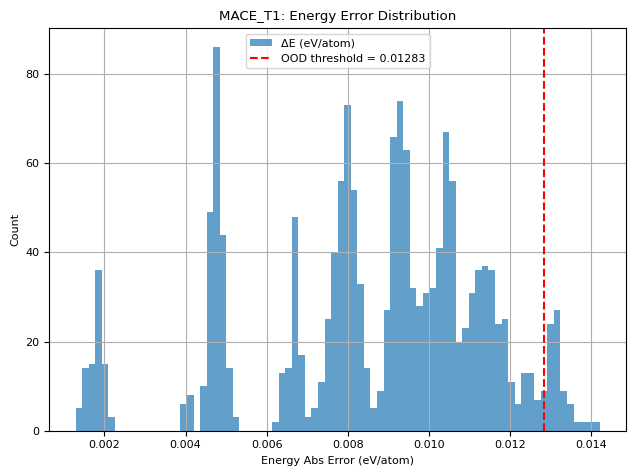

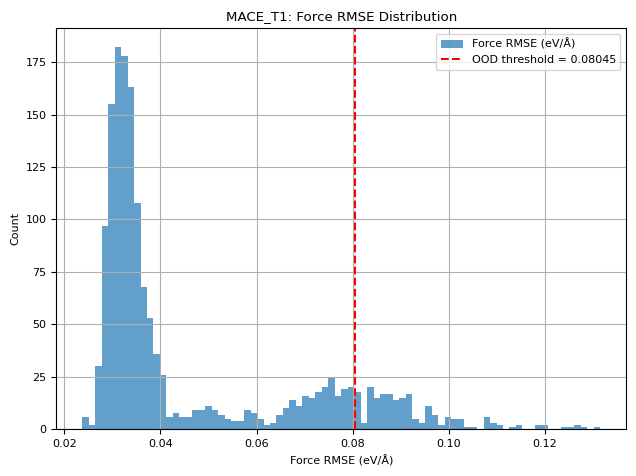

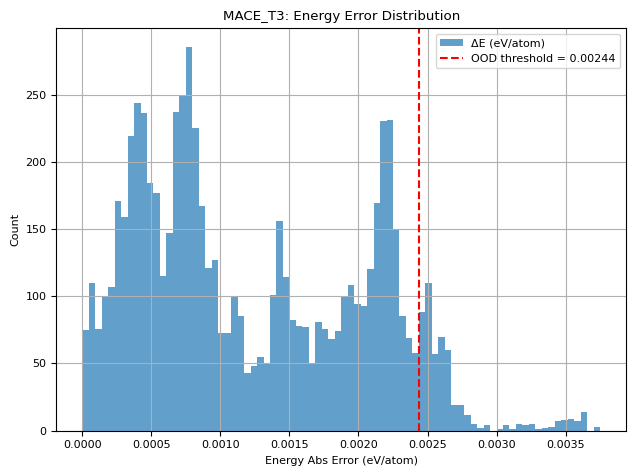

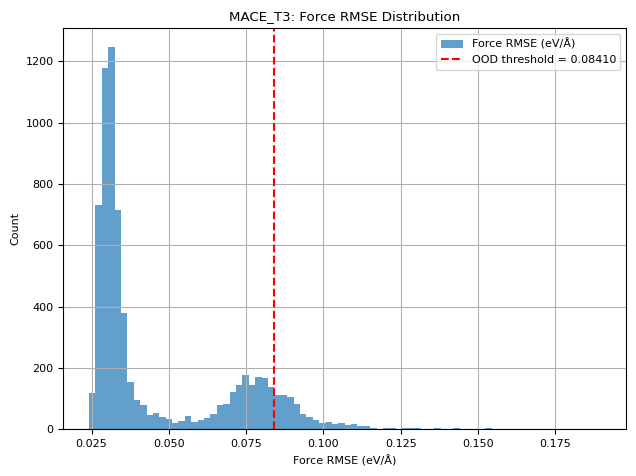

In [43]:
import json
import numpy as np
import matplotlib.pyplot as plt

# === Load results
with open("/home/phanim/harshitrawat/summer/final_work/ood_per_model_dynamic.json") as f:
    data = json.load(f)

results = data["results"]
thresholds = data["thresholds"]
stats = data["stats"]  # already contains mu_E, std_E, etc. per model

# === Organize by model
models = ["MACE_T1", "MACE_T3"]
model_data = {m: [] for m in models}
for d in results:
    model_data[d["model"]].append(d)

# === Plot + FULL Summary per model
for model in models:
    entries = model_data[model]
    energy_err = np.array([d["energy_abs_error_per_atom"] for d in entries])
    force_rmse = np.array([d["force_per_atom_RMSE"] for d in entries])
    is_ood = np.array([d["is_OOD"] for d in entries])

    n_total = len(entries)
    n_ood = int(np.sum(is_ood))
    ood_pct = 100 * n_ood / n_total if n_total else 0

    thresh_E = thresholds[model]["energy"]
    thresh_F = thresholds[model]["force"]
    mu_E = stats[model]["mu_E"]
    std_E = stats[model]["std_E"]
    mu_F = stats[model]["mu_F"]
    std_F = stats[model]["std_F"]

    print(f"\n {model} Summary:")
    print(f"  Total structures           : {n_total}")
    print(f"  Total OOD structures       : {n_ood}")
    print(f"  OOD rate                   : {ood_pct:.2f}%")
    print(f"  Energy threshold (μ + {k}σ) : {thresh_E:.5f} eV/atom")
    print(f"  Force  threshold (μ + {k}σ)  : {thresh_F:.5f} eV/Å")

    print(f"\n  Energy Abs Error Stats:")
    print(f"    Mean       : {mu_E:.5f}")
    print(f"    Std Dev    : {std_E:.5f}")
    print(f"    Min        : {np.min(energy_err):.5f}")
    print(f"    Max        : {np.max(energy_err):.5f}")

    print(f"\n  Force RMSE Stats:")
    print(f"    Mean       : {mu_F:.5f}")
    print(f"    Std Dev    : {std_F:.5f}")
    print(f"    Min        : {np.min(force_rmse):.5f}")
    print(f"    Max        : {np.max(force_rmse):.5f}")

    # === Plot Energy Error
    plt.figure()
    plt.hist(energy_err, bins=80, alpha=0.7, label="ΔE (eV/atom)")
    plt.axvline(thresh_E, color='r', linestyle='--', label=f'OOD threshold = {thresh_E:.5f}')
    plt.xlabel("Energy Abs Error (eV/atom)")
    plt.ylabel("Count")
    plt.title(f"{model}: Energy Error Distribution")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{model}_energy_error_distribution.png")

    # === Plot Force RMSE
    plt.figure()
    plt.hist(force_rmse, bins=80, alpha=0.7, label="Force RMSE (eV/Å)")
    plt.axvline(thresh_F, color='r', linestyle='--', label=f'OOD threshold = {thresh_F:.5f}')
    plt.xlabel("Force RMSE (eV/Å)")
    plt.ylabel("Count")
    plt.title(f"{model}: Force RMSE Distribution")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{model}_force_rmse_distribution.png")

print("\n✅ All plots + stats printed and saved.")
